In [1]:
import numpy as np
from KnackpackData import getEncoded,weights,values,max_weight,n_items
max_weight = np.float32(max_weight)
values = values.astype('float32')
weights = weights.astype('float32')
print(values)
print(weights)

[0.7941186  0.36126158 0.41610393 0.58425814 0.7601718  0.18780841
 0.28816715 0.6702189  0.49964827 0.17856868 0.4131413  0.19919524
 0.5316994  0.8323707  0.18525094 0.9573592 ]
[0.26202467 0.15868397 0.2781265  0.45931688 0.32100055 0.5183928
 0.26194292 0.9760853  0.73281455 0.11527423 0.38627508 0.6285012
 0.12505792 0.9835486  0.44322488 0.78955835]


In [2]:
from numba import njit,prange
@njit("int32(boolean[::1],boolean[::1])",nogil = True,fastmath=True)
def dominates(first, second):
    thisWeight= 0
    thisValue = 0
    otherWeight = 0
    otherValue= 0
    for i in prange(n_items):
        if first[i]:
            thisWeight += weights[i]
            thisValue  += values[i]
        if second[i]:
            otherWeight += weights[i]
            otherValue +=values[i]
    if thisWeight>max_weight:
        thisValue = -1
    if otherWeight>max_weight:
        otherValue = -1
    if (thisValue >= otherValue and thisWeight < otherWeight) or (thisValue > otherValue and thisWeight <= otherWeight):
        return 1
    elif (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight):
        return -1
    else:
        return 0
@njit(nogil = True,fastmath=True,parallel = True)
def getResult(population):
    res = np.zeros(len(population))
    for i in prange(len(population)):
        for j in prange(len(population)):
            res[i] += dominates(population[i],population[j])
    return res

In [3]:
population = getEncoded()
print(len(population))
%time results = getResult(population)

65536
CPU times: user 2min 9s, sys: 42.2 ms, total: 2min 9s
Wall time: 16.6 s


61761.0
65536
63560


array([ True,  True,  True,  True,  True, False, False, False, False,
        True, False, False,  True, False, False, False])

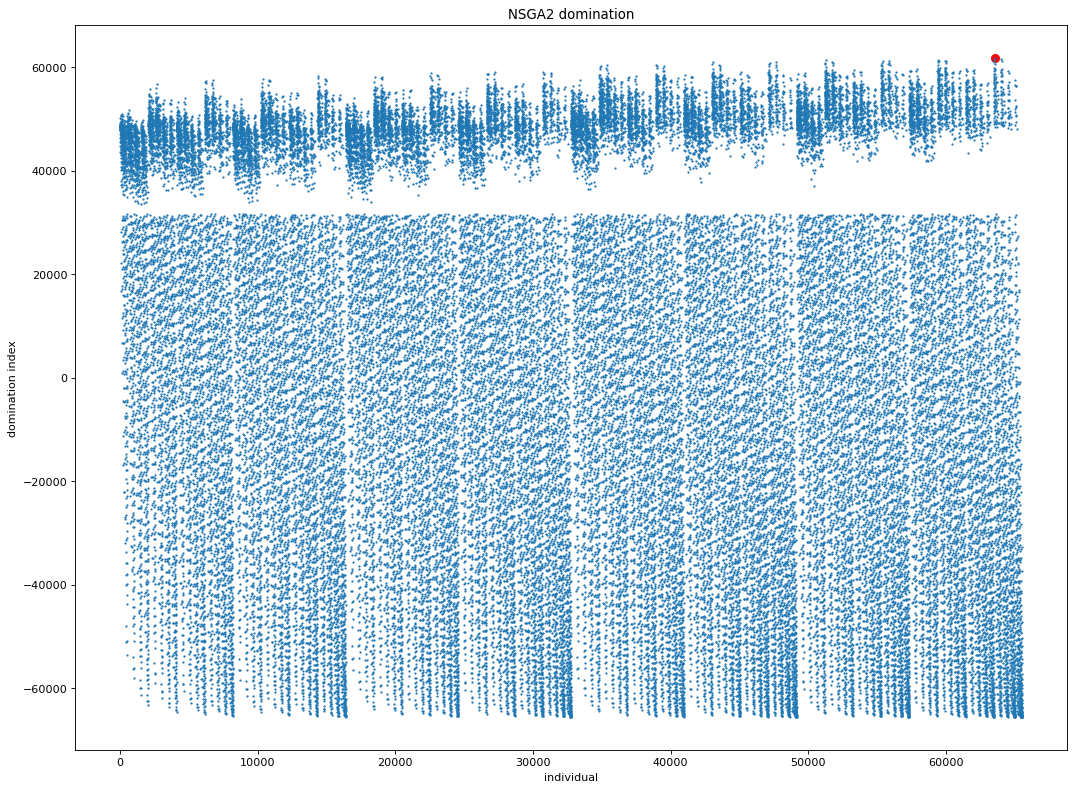

In [10]:
import matplotlib.pyplot as plt
best_index = np.argmax(results)
best_index
print(results[best_index])
plt.figure(figsize=(16, 12), dpi=80)
plt.title("NSGA2 domination")
plt.xlabel("individual decimal  val")
plt.ylabel("domination index")
plt.scatter(best_index,results[best_index],c="r",s=50)
plt.scatter(range(len(results)),results,s=1)
print(len(results))
print(best_index)
population[best_index]

In [11]:
def grayCode(n):
 
    # Right Shift the number
    # by 1 taking xor with
    # original number
    return n ^ (n >> 1)
order = np.array([grayCode(i) for i in range(len(results))])
gray_code_result = results[order]

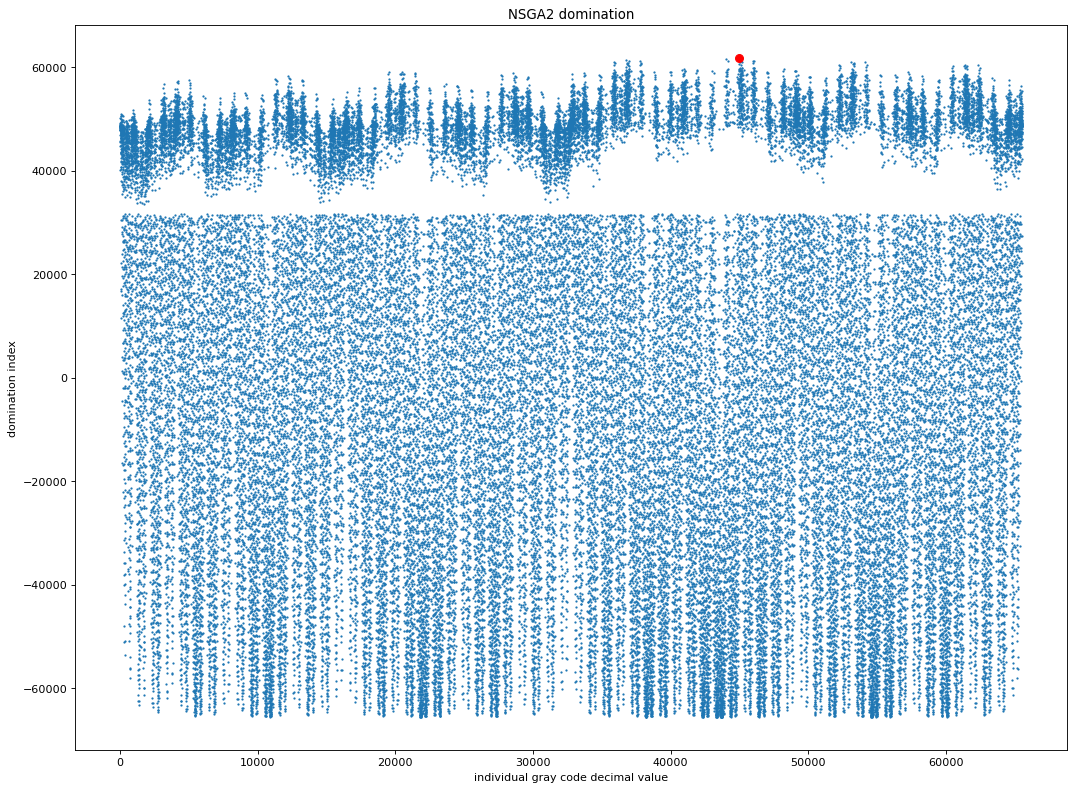

In [12]:
best_index = np.argmax(gray_code_result)
plt.figure(figsize=(16, 12), dpi=80)
plt.title("NSGA2 domination")
plt.xlabel("individual gray code decimal value")
plt.ylabel("domination index")
plt.scatter(range(len(gray_code_result)),gray_code_result,s=1)
plt.scatter(best_index,gray_code_result[best_index],c="r",s=50)